<a href="https://colab.research.google.com/github/allison-s010/Final-PCNA-Project/blob/main/project/3layerCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/allison-s010/Final-PCNA-Project.git
%cd Final-PCNA-Project

(array([893, 893, 894, ..., 954, 955, 955]),
 array([1530, 1531, 1528, ..., 1500, 1491, 1492]))

In [ ]:
#training the 3 layer CNN

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import numpy as np
from pathlib import Path

# ------------------ Dataset ------------------
class TiffFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        classes = sorted([d.name for d in os.scandir(root_dir) if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for file_name in os.listdir(cls_dir):
                if file_name.endswith(".tif"):
                    self.samples.append((os.path.join(cls_dir, file_name), self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        # Read TIFF as float32 for normalization
        img_np = tiff.imread(path).astype(np.float32)

        # Normalize raw image array to [0,1]
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

        # Convert to 8-bit for PIL compatibility
        img_np_8bit = (img_np * 255).astype(np.uint8)

        img = Image.fromarray(img_np_8bit)

        # Convert to RGB if not already
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# ------------------ Transforms ------------------
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=(-180, 180), expand=False),  # Full ±180 degrees rotation
    transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 2.5)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
])

# ------------------ Paths & Data ------------------
DATASET_PATH = "/content/Final-PCNA-Project/project/pcna_dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_data = TiffFolderDataset(os.path.join(DATASET_PATH, "train"), transform=train_transform)
val_data = TiffFolderDataset(os.path.join(DATASET_PATH, "val"), transform=val_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

# ------------------ Plot Saving Directory ------------------
PLOTS_DIR = "/content/Final-PCNA-Project/project/plots"
Path(PLOTS_DIR).mkdir(parents=True, exist_ok=True)

# ------------------ Save Augmented Examples Individually ------------------
def save_augmented_examples_individually_as_tiff(dataset, n=5):
    """
    Save 'n' augmented examples individually as TIFF files for inspection.
    """
    for i in range(n):
        img, label = dataset[i]
        img = torch.clamp(img, 0, 1)

        np_img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        filename = os.path.join(PLOTS_DIR, f"train_aug_sample_{i+1}_label_{label}.tif")
        tiff.imwrite(filename, np_img)
        print(f"✅ Saved: {filename}")

print("Saving augmented training examples for inspection...")
save_augmented_examples_individually_as_tiff(train_data, n=5)


# ------------------ 3-Layer CNN ------------------
class ThreeLayerCNN(nn.Module):
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 32, 32]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, 16, 16]
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------ Model Setup ------------------
model = ThreeLayerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# ------------------ Training ------------------
num_epochs = 100
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation step (accuracy)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

# ------------------ Save Model ------------------
torch.save(model.state_dict(), "pcna_3layer_cnn.pth")
print("✅ Model saved as pcna_3layer_cnn.pth")

# ------------------ Plot Loss Curve ------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "training_loss_curve.png"))
plt.show()

# ------------------ Plot Validation Accuracy Curve ------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy vs Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "validation_accuracy_curve.png"))
plt.show()


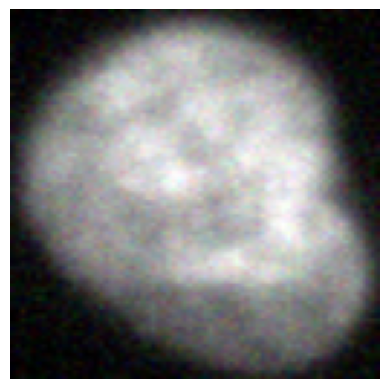

Image: nikon1_img3_cell_img_label_4_rot-180_noise.tif
True Label     : s_phase
Predicted Label: s_phase
Prediction Type: ✅ True Positive (TP)


In [ ]:
import os
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
from torchvision import transforms
from torch import nn

# ------------------ Display Helper ------------------
def imshow_tensor(img_tensor):
    img = img_tensor * 0.5 + 0.5  # De-normalize
    img = img.clamp(0, 1)
    if img.shape[0] == 1:
        img = img.squeeze(0)
        plt.imshow(img.cpu(), cmap='gray')
    else:
        img = img.permute(1, 2, 0)
        plt.imshow(img.cpu())
    plt.axis('off')
    plt.show()

# ------------------ Model (3-layer CNN) ------------------
class ThreeLayerCNN(nn.Module):
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 64, 64]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 32, 32]
        x = self.pool(torch.relu(self.conv3(x)))  # [B, 128, 16, 16]
        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------ Paths & Config ------------------
DATASET_PATH = "/content/Final-PCNA-Project/project/pcna_dataset"
MODEL_PATH = "pcna_3layer_cnn.pth"
class_names = ['non_s_phase', 's_phase']  # Keep same class order as training
positive_class = "s_phase"

# ------------------ Load Model ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ThreeLayerCNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ------------------ Transforms (must match training) ------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    transforms.Normalize([0.5] * 3, [0.5] * 3),
])

# ------------------ Pick Random Validation Image ------------------
val_dir = os.path.join(DATASET_PATH, "val")
all_samples = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(val_dir, class_name)
    tif_files = [f for f in os.listdir(class_dir) if f.endswith(".tif")]
    for tif_file in tif_files:
        all_samples.append((os.path.join(class_dir, tif_file), class_idx, class_name))

random_path, true_label_idx, true_label_name = random.choice(all_samples)

# ------------------ Load and Preprocess Image ------------------
img_np = tiff.imread(random_path)
if img_np.ndim == 2:
    img = Image.fromarray(img_np).convert('RGB')
else:
    img = Image.fromarray(img_np)
    if img.mode != 'RGB':
        img = img.convert('RGB')

img_tensor = transform(img)

# ------------------ Predict ------------------
input_tensor = img_tensor.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(input_tensor)
    _, pred_idx = torch.max(output, 1)

predicted_label_name = class_names[pred_idx.item()]

# ------------------ Display and Print ------------------
imshow_tensor(img_tensor)
print(f"Image: {os.path.basename(random_path)}")
print(f"True Label     : {true_label_name}")
print(f"Predicted Label: {predicted_label_name}")

# ------------------ Evaluate Result ------------------
if predicted_label_name == positive_class:
    if true_label_name == positive_class:
        condition = "✅ True Positive (TP)"
    else:
        condition = "❌ False Positive (FP)"
else:
    if true_label_name == positive_class:
        condition = "❌ False Negative (FN)"
    else:
        condition = "✅ True Negative (TN)"

print(f"Prediction Type: {condition}")


In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

    # Calculate metrics as percentages
    accuracy = 100 * (tp + tn) / (tp + tn + fp + fn)
    precision = 100 * tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0  # TPR
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    fpr = 100 * fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = 100 * fn / (fn + tp) if (fn + tp) > 0 else 0
    tnr = 100 * tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"Validation Metrics:")
    print(f"  Accuracy:           {accuracy:.2f}%")
    print(f"  Precision (PPV):    {precision:.2f}%")
    print(f"  Recall (TPR):       {recall:.2f}%")
    print(f"  True Negative Rate: {tnr:.2f}%")
    print(f"  False Positive Rate:{fpr:.2f}%")
    print(f"  False Negative Rate:{fnr:.2f}%")
    print(f"  F1 Score:           {f1_score:.2f}%")

# Call it right after training loop:
evaluate_model(model, val_loader, device)


NameError: name 'model' is not defined